In [11]:
from btgenerate.database.database import Database
from btgenerate.database.dataloader import LiquidMasterDataSet
from pprint import PrettyPrinter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pp = PrettyPrinter(width=80, compact=True)
%reload_ext autoreload
%autoreload 1
%aimport btgenerate.chemicals.chemical
%aimport btgenerate.database.database


In [12]:
db = Database(db="FMT")
df = db.pull(table="Liquid Master Table")

ds_lm = LiquidMasterDataSet(df)
ds_lm.map_names()
ds_lm.normalize_components(by="total_mass(g)", inplace=True)

In [13]:
df.loc[~df["lab_batch"].isna()]

,Electrolyte ID,lab_batch,note,total_mass(g),generation_method,generation_project,experiment,LiPF6,LiTFSI,LiFSI,...,TFMB,Conductivity,Voltage,Cycles,LCE,Initial Li efficiency,generation_id,Predicted Conductivity,Predicted Voltage,Predicted LCE
154,21-1-41,6.0,b'baseline',10.026,manual,DOE_electrolyte,BL-1,0.058,1.146,0.000,...,NaN,NaN,NaN,43.0,0.928058,0.888592,NaN,0.0,0.0,NaN
155,21-1-42,6.0,b'128 day 2 reference',4.989,manual,DOE_electrolyte,None,0.000,0.586,0.000,...,NaN,NaN,NaN,9.0,0.729730,1.199820,NaN,0.0,0.0,NaN
156,21-1-43,6.0,b'Batch 6',5.068,manual,DOE_electrolyte,None,0.151,0.113,0.541,...,NaN,0.006577,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
157,21-1-44,6.0,b'Batch 6',5.043,manual,DOE_electrolyte,None,0.059,0.093,0.280,...,NaN,0.004112,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
158,21-1-45,6.0,b'Batch 6',5.008,manual,DOE_electrolyte,None,0.004,0.283,0.352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,21-7-631,77.0,b'21-7-32 w/ 9% DTD',18.000,manual,DOE_electrolyte,DTD_trial,0.072,1.186,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN,NaN
795,21-7-634,77.0,b'4 M LiFSI in DMC [supersaturated]',18.000,manual,DOE_electrolyte,None,0.000,0.000,9.398,...,NaN,NaN,NaN,NaN,NaN,NaN,155.0,NaN,NaN,NaN
796,21-7-639,77.0,b'21-7-377 switch DTO for DTD',18.001,manual,DOE_electrolyte,DTD_trial,1.017,0.778,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,NaN,NaN
797,21-7-640,77.0,b'21-7-378 switch DTO for DTD',17.999,manual,DOE_electrolyte,DTD_trial,1.183,1.330,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,153.0,NaN,NaN,NaN


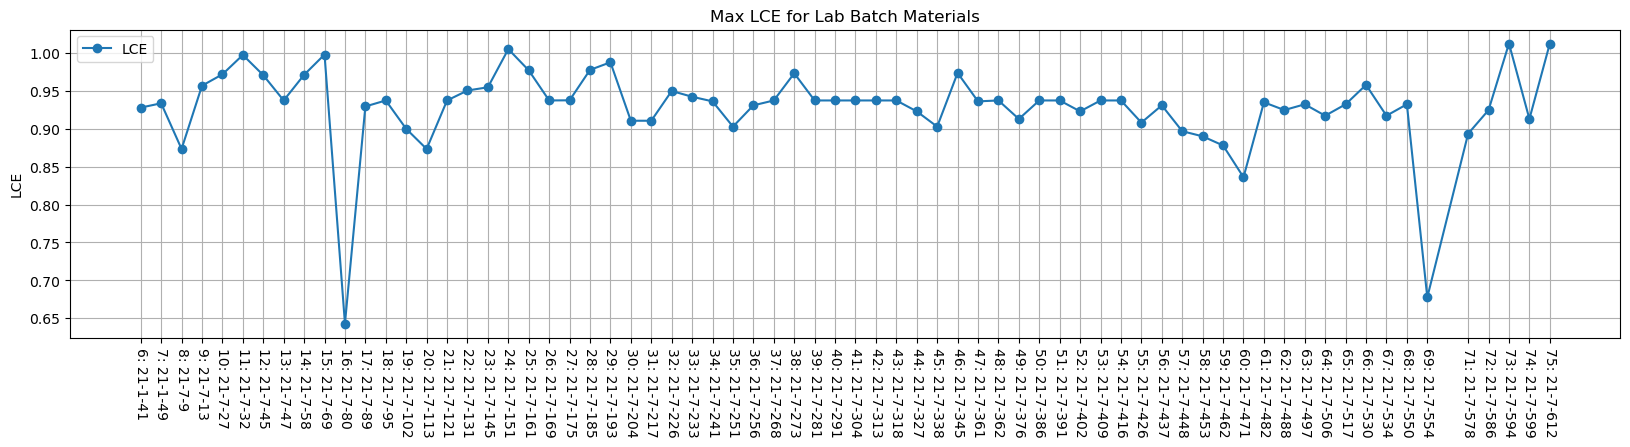

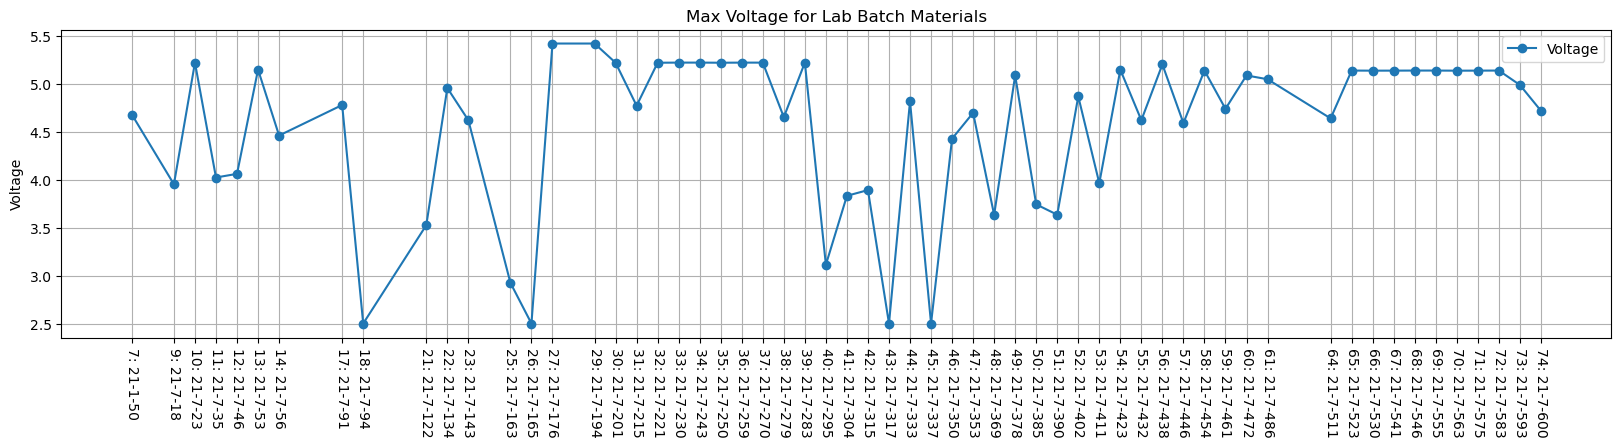

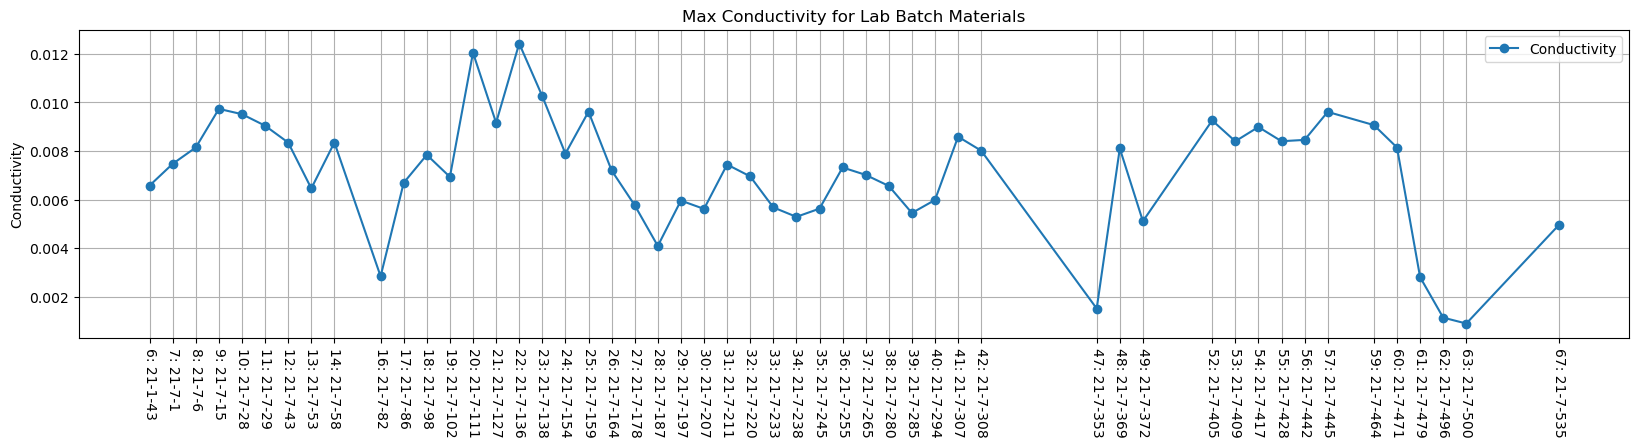

In [14]:
df = ds_lm.dataframe
for target in ["LCE", "Voltage", "Conductivity"]:

    indices_batch_max = []
    problematic_batches = []
    for batch, indices in df.groupby("lab_batch").groups.items():
        index_batch_max = df.loc[indices, target].idxmax()
        if not np.isnan(index_batch_max):
            indices_batch_max.append(index_batch_max)
        else:
            problematic_batches.append(batch)
    df_ = df.loc[indices_batch_max, ["lab_batch", "Electrolyte ID", target]]

    fig, ax = plt.subplots(figsize=(20,4))
    df_.plot(x="lab_batch", y=target, marker="o", ax=ax)
    ax.set_xticks(df_["lab_batch"])
    ticks = list(map(lambda x: str(int(x[0])) + ": " + x[1], df_.loc[:, ["lab_batch","Electrolyte ID"]].to_numpy()))
    ax.set_xticklabels(ticks, rotation=-90, ha="center", va="top")
    # if target == "LCE":
    #     ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel("")
    ax.set_title(f"Max {target} for Lab Batch Materials")
    ax.set_ylabel(target)
    ax.legend()
    ax.grid(1)

In [15]:
df_ = ds_lm.dataframe.dropna(subset=["LCE", "Predicted LCE"])
df_["id"] = df["Electrolyte ID"].str.replace("-", "").astype(int)
df_ = df_.sort_values(axis="index", by="id")
df_ = df_.loc[:, ["Electrolyte ID", "LCE", "Predicted LCE"]].reset_index(drop=True)

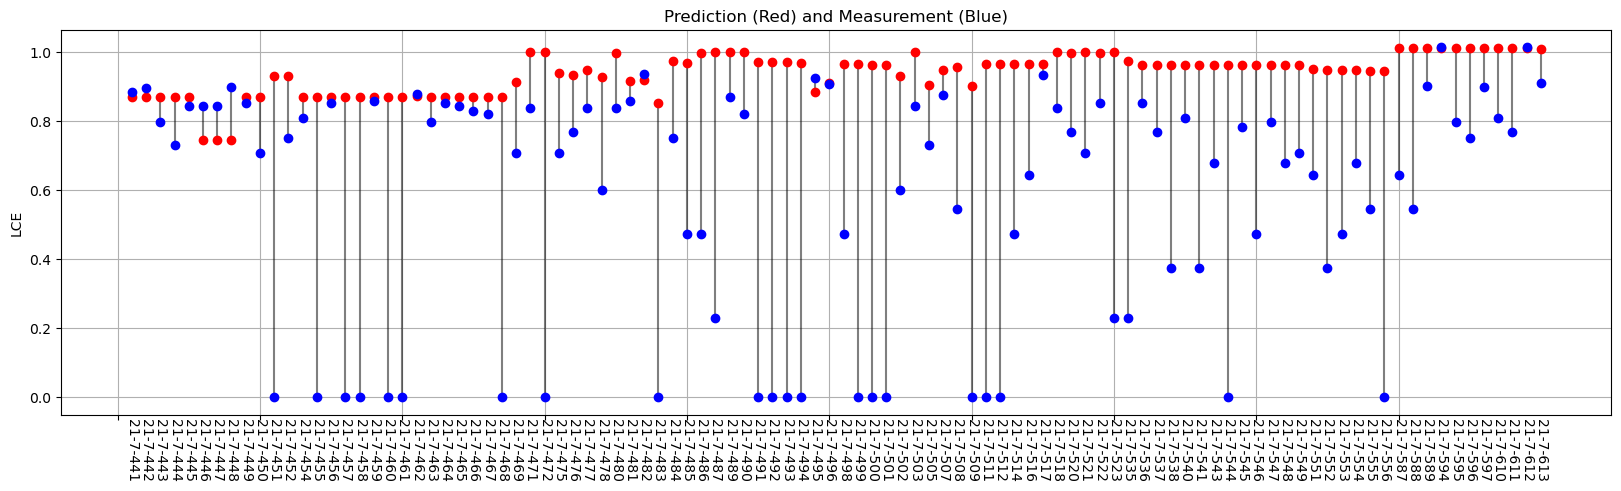

In [16]:
num_from_last = 100
fig, ax = plt.subplots(figsize=(20,5))
for row in df_.tail(num_from_last).iterrows():
    ax.plot([row[0]]*2, [row[1]["LCE"], row[1]["Predicted LCE"]], color="k", alpha=0.5)
    ax.plot(row[0], row[1]["Predicted LCE"], color="r", marker="o")
    ax.plot(row[0], row[1]["LCE"], color="b", marker="o")
    ax.text(row[0], -0.06, row[1]["Electrolyte ID"], rotation=-90, ha="center", va="top")
ax.set_xticks(np.arange(row[0]-num_from_last, row[0], 10))
ax.set_xticklabels([])
ax.set_title("Prediction (Red) and Measurement (Blue)")
ax.set_ylabel("LCE")
ax.grid(1, which="both", )
plt.show()

In [17]:
db = Database(db="bo_experiments")
df = db.pull(table="validated_lce_v1")

In [18]:
ds_lm = LiquidMasterDataSet(df)
ds_lm.map_names()
ds_lm.normalize_components(by="total_mass", inplace=True)
df_sort = ds_lm.dataframe.sort_values(axis="index", by="Electrolyte ID")

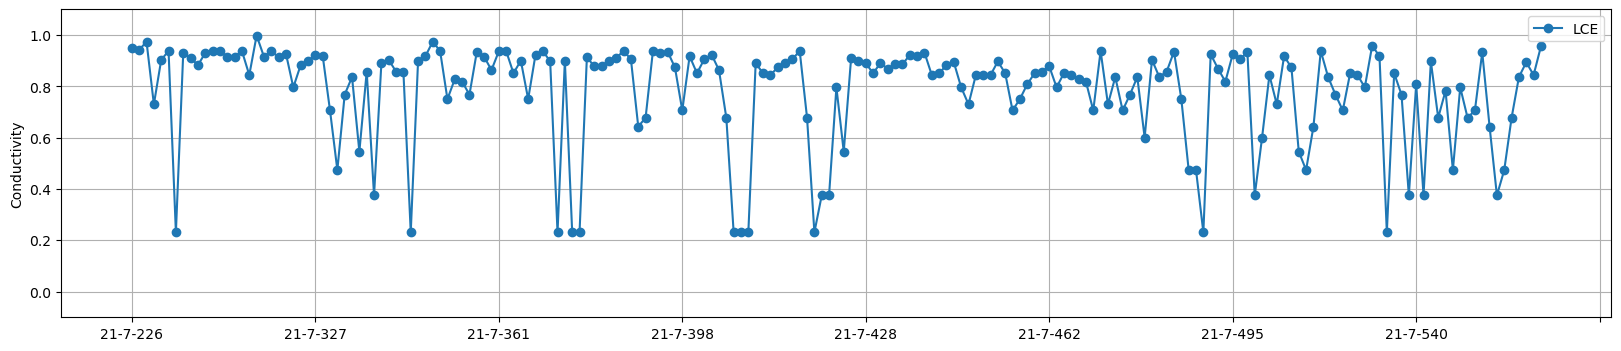

In [19]:
fig, ax = plt.subplots(figsize=(20,4))
df_sort.plot(x="Electrolyte ID", y="LCE", marker="o", ax=ax)
# ax.set_xticks(df_sort["lab_batch"])
# ticks = list(map(lambda x: str(int(x[0])) + ": " + x[1], df_.loc[:, ["lab_batch","Electrolyte ID"]].to_numpy()))
# ax.set_xticklabels(ticks, rotation=-90, ha="center", va="top")
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel("")
ax.set_ylabel(target)
ax.legend()
ax.grid(1)

In [11]:
df_sort.tail(7).loc[:, ["Electrolyte ID","LCE"]]

,Electrolyte ID,LCE
189,21-7-552,0.375000
194,21-7-553,0.473684
190,21-7-554,0.677419
191,21-7-577,0.836066
192,21-7-578,0.893617
193,21-7-583,0.843750
195,21-7-584,0.955581


In [12]:
df_sel = df_cy.loc[df_cy["Method"] == "Aurbach"]
features = df_sel.loc[:, ['FC', 'OC', 'FO', 'InOr', 'F', 'sF', 'aF', 'O', 'sO', 'aO', 'C', 'sC', 'aC']]
targets = df_sel.loc[:, ["LLCE"]]

In [23]:
df_cy["Cycle"] = pd.to_numeric(df_cy["Cycle"], errors="coerce")

<AxesSubplot: xlabel='Cycle'>

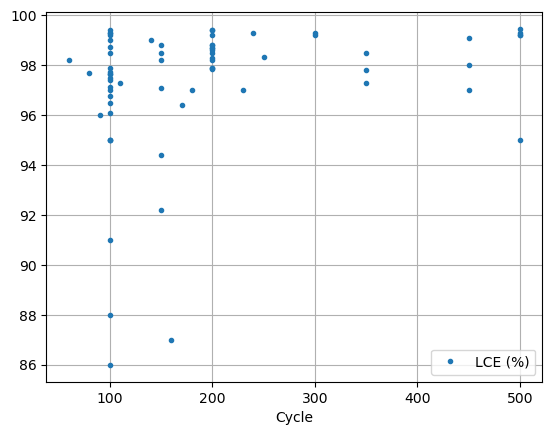

In [33]:
df_cy.loc[(df_cy["Cycle"]>50), ["Cycle", "LCE (%)"]].plot(x="Cycle", y="LCE (%)", marker=".", ls="", grid=True)